# Finding the Optimal Shape for Rotation

## Hyperparameters of Optimization Experiment

Alter the values in the next cell to perform different optimization experiments.

You can alter the aspect ratio of the boxes being optimized, the ways to generate the dataset, and what shape the optimization starts with.

In [5]:
# HYPER PARAMETERS

# Width / Height Ratio
aspect_ratio = 1

dataset = "dataset1"

# function to return shapely Polygon
# the optimization process will begin with this shape
starting_shape_method = make_triangle

### Downloading Support Files

This includes downloading the LaTeX font.

In [1]:
!wget -q https://github.com/dominictarr/computer-modern/raw/master/serif/cmunrm.ttf

### Functions to Generate Shapes

The below functions generate octagons, triangles, pentagons, random shapes, etc. These shapes will be used in the following cells.

In [2]:
from shapely.geometry import Polygon, Point
import numpy as np

# returns polygon with eight sides
# omega controls proportion of sides
def make_octagon(w, h, omega):
    return Polygon([(int(w*(1-2*omega)), h), (w, int(h*(1-2*omega))), (w, -int(h*(1-2*omega))), (int(w*(1-2*omega)), -h), 
                    (-int(w*(1-2*omega)), -h), (-w, -int(h*(1-2*omega))), (-w, int(h*(1-2*omega))), (-int(w*(1-2*omega)), h)])
    
# returns polygon with three sides
# triangle tip is off to the left
def make_triangle(w, h):
    return Polygon([(w,h), (w, -h), (-w, 0)])
    
# returns regular pentagon with tip
# pointing upwards
def make_pentagon(w,h):
    return Polygon([(0,h), (w, h*np.sin(18 * np.pi / 180)), (w * np.cos(54 * np.pi / 180), -h*np.sin(54 * np.pi / 180)),
                    (-w * np.cos(54 * np.pi / 180), -h*np.sin(54 * np.pi / 180)), (-w, h*np.sin(18 * np.pi / 180))])

# make ellipse with 'cuts' samples
# i.e. 360 cuts means there's a degree between each sample
def make_ellipse(w, h, cuts):
    points = []
    
    for i in range(cuts):
        deg = i*(360/cuts)*3.14/180
        points.append((w*np.sin(deg), h*np.cos(deg)))
    return Polygon(points)

# make random shape by sampling points on the bounding box
def make_random_shape(w, h, kps=1):
    coords = []
    for k in range(kps):
        coords.extend([(2*w*random.random()-w, h), (-w, 2*h*random.random()-h), 
                       (2*random.random()*w-w, -h), (w, 2*random.random()*h-h)])
    return Polygon(coords)

### Geometry Support Functions

Various functions, including IoU, getting coordinates, refitting a box around a rotated polygon, etc.

In [3]:
from shapely.affinity import rotate
from shapely.geometry import Polygon, Point
import numpy as np
import random

# return IoU between two shapely Polygon
def get_iou(a, b):
    return a.intersection(b).area / a.union(b).area

# return NumPy array of coordinates for shapely Polygon
def get_coords(poly):
    return np.array([x for x in poly.exterior.coords])

def find_random_box(x, y, w, h, deg, version):
    
    # generate random shape
    if version == "dataset1":
        test = make_random_shape(w, h, 1)
        
    # rotate shape
    rot_box = rotate(test, deg)
    
    # refit bbox
    pts = get_coords(rot_box)
    x1, y1 = np.min(pts, axis=0)
    x2, y2 = np.max(pts, axis=0)
    w = (x2-x1)/2
    h = (y2-y1)/2
    x = w+x1
    y = h+y1
    return x, y, w, h

# resample coordinates to have higher resolution
# useful for optimization process
def single_parametric_interpolate(obj_x_loc, obj_y_loc, numPts=50):
    n = len(obj_x_loc)
    vi = [[obj_x_loc[(i+1)%n] - obj_x_loc[i],
         obj_y_loc[(i+1)%n] - obj_y_loc[i]] for i in range(n)]
    si = [np.linalg.norm(v) for v in vi]
    di = np.linspace(0, sum(si), numPts, endpoint=False)
    new_points = []
    for d in di:
        for i,s in enumerate(si):
            if d>s: d -= s
            else: break
        l = d/s
        new_points.append([obj_x_loc[i] + l*vi[i][0],
                           obj_y_loc[i] + l*vi[i][1]])
    return new_points


### Tensorflow Geometry Functions

These geometry functions are written to support Tensorflow tensors and will be used to construct the optimization graph.

In [4]:
import tensorflow as tf

# rotate polygon coordinates stored in Tensorflow tensor
def rotate_coords(coords, deg):
    rads = deg*3.14/180
    xs = coords[:, 0:1]
    ys = coords[:, 1:2]
    new_xs = xs*tf.cos(rads) - ys*tf.sin(rads)
    new_ys = xs*tf.sin(rads) + ys*tf.cos(rads)
    return tf.concat([new_xs, new_ys], axis=1)

# convert bbox from XYWH 2 XYXY
def xywh2xyxy(box):
    x1 = box[:,0] - box[:, 2]
    x2 = box[:,0] + box[:, 2]
    y1 = box[:,1] - box[:, 3]
    y2 = box[:,1] + box[:, 3]
    return ([x1, y1, x2, y2])

# compute iou between two Tensorflow boxes
def tf_iou(b1, b2):
    b1x1, b1y1, b1x2, b1y2 = b1
    b2x1, b2y1, b2x2, b2y2 = b2
    area1 = (b1y2-b1y1)*(b1x2-b1x1)
    area2 = (b2y2-b2y1)*(b2x2-b2x1)
    x1 = tf.maximum(b1x1, b2x1)
    x2 = tf.minimum(b1x2, b2x2)
    y1 = tf.maximum(b1y1, b2y1)
    y2 = tf.minimum(b1y2, b2y2)
    inter = (y2-y1)*(x2-x1)
    iou = inter/(area1+area2-inter)
    return tf.reduce_mean(iou)

### Generating Dataset to Optimize Over

Generate the random shapes with which to compute the expected IoU.

In [6]:
session = tf.Session()

# extra parameters
w, h = 50, 50 / aspect_ratio
max_deg = 360
deg_steps = 5
box_samples = 1000 # number of box samples to optimize over

In [7]:
# generate dataset samples, for each rotation
deg_boxes = []
deg_samples = max_deg // deg_steps
for ii, deg in enumerate(range(0, max_deg, deg_steps)):
    boxes = []
    for s in range(box_samples):
        
        if s % 30 == 0:
            progress = (ii * box_samples + s) / (deg_samples * box_samples)
            print("%.02f%% Completed" % (progress * 100), end='\r')

        boxes.append(find_random_box(0,0,w,h,deg,dataset))
    deg_boxes.append(tf.constant(boxes))

### Generating Starting Shape

Create the starting shape of the optimization process.

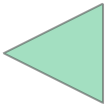

In [8]:
# generate starting shape
keypoints = 360
starting_shape = get_coords(starting_shape_method(w,h))
shape = single_parametric_interpolate(starting_shape[:, 0], starting_shape[:, 1], numPts=keypoints)[1:]
Polygon(shape)

### Setting up Tensorflow graph of Optimization

Setting up the Tensorflow computation for approximating the Expected IoU of a particular bounding box.

In [9]:
# optimizing shape:
init_tf = tf.Variable(shape)
all_iou = 0
global_step = tf.Variable(0, trainable=False)

# set up differentiable IoU Tensorflow graph
# to optimize over later
for ii, deg in enumerate(range(0, max_deg, deg_steps)):

    # rotate coordinates of shape to given rotation
    coords = rotate_coords(init_tf, deg=deg)

    # compute resulting bounding box
    x1, y1, x2, y2 = tf.reduce_min(coords[:, 0]), tf.reduce_min(coords[:, 1]), tf.reduce_max(coords[:, 0]), tf.reduce_max(coords[:, 1])
    box = [x1, y1, x2, y2]

    # compute IoU between optimizing shape bbox and dataset bboxes
    all_boxes = deg_boxes[ii]
    init_tf_xy = box
    all_tf_xy = xywh2xyxy(all_boxes)
    iou = tf_iou(init_tf_xy, all_tf_xy)
    
    # store IoU
    all_iou += iou


## Performing Optimization

Computing the expected IoU of our optimizing shape and using Gradient Descent to alter the shape in a way that improves it.

When fitting the new bounding box to calculate expected IoU, only the outermost corners of the shape are revelant. So the shape is periodically updated to its convex hull to get more reasonable results.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 0:


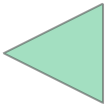

Iter 100:


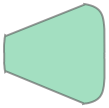

Iter 200:


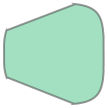

Iter 300:


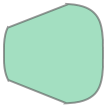

Iter 400:


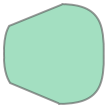

Iter 500:


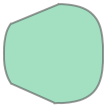

Iter 600:


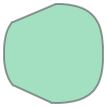

Iter 700:


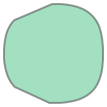

Iter 800:


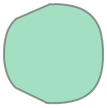

Iter 900:


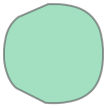

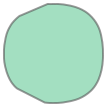

In [10]:
starter_learning_rate = 5.
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 40.,0.99)

# Passing global_step to minimize() will increment it at each step.
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate).minimize(-all_iou, global_step=global_step)

# storing IoU and polygons during optimization
sample_polygons = []
sample_ious = []

session.run(tf.global_variables_initializer())
for i in range(1000):

    # save the current polygon
    coords = (init_tf.eval(session=session))
    polygon = Polygon(coords)
    sample_polygons.append(polygon)
    
    # convert optimized shape to its convex hull
    # every 30 iterations
    if i % 30 == 0:
        hull = polygon.convex_hull
        coords = get_coords(hull)
        shape = single_parametric_interpolate(coords[:, 0], coords[:, 1], numPts=keypoints)[1:]
        session.run(tf.assign(init_tf, shape))

    # display current optimized polygon
    # every 100 iterations
    if i % 100 == 0:
        print("Iter %d:" % i)
        display(polygon)
        
    _, iou2, crds_shape = session.run([opt, all_iou, init_tf])
    sample_ious.append(iou2)
    
# convert mean IoUs
sample_ious = np.array(sample_ious) / (360 / 5)

# final polygon
coords = (init_tf.eval(session=session))
final_polygon = Polygon(coords)
final_polygon

## Compute Expected IoU with Ellipse and Largest Box

In addition to optimizing the shape, it's useful to view the expected IoU with the ellipse-rotated bounding box and the "largest box" bounding box.

In [11]:

# compute expected IoU of generated dataset with ellipse method
ell_coords = get_coords(make_ellipse(w,h,cuts=360))
tf_ell_interp = single_parametric_interpolate(ell_coords[:, 0], ell_coords[:, 1], numPts=keypoints)[1:]
session.run(tf.assign(init_tf, tf_ell_interp))
ell_iou = session.run(all_iou) / (360 / 5)

# compute expected IoU of generated dataset with largest box method
lrg_coords = get_coords(make_octagon(w,h,omega=0))
tf_rect_interp = single_parametric_interpolate(lrg_coords[:, 0], lrg_coords[:, 1], numPts=keypoints)[1:]
session.run(tf.assign(init_tf, tf_rect_interp))
lrg_iou = session.run(all_iou) / (360 / 5)

/home/appuser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


# Graphing Results

Finally, we graph all the results and see how the IoU changed over time, how the Ellipse and Largest Box methods perform compared to using the optimized shape.

In [12]:
# Graph Hyperparameters
lim = 1000 # limit of iterations to graph
num_snapshots = 5 # number of times to display a polygon

<Figure size 432x288 with 0 Axes>

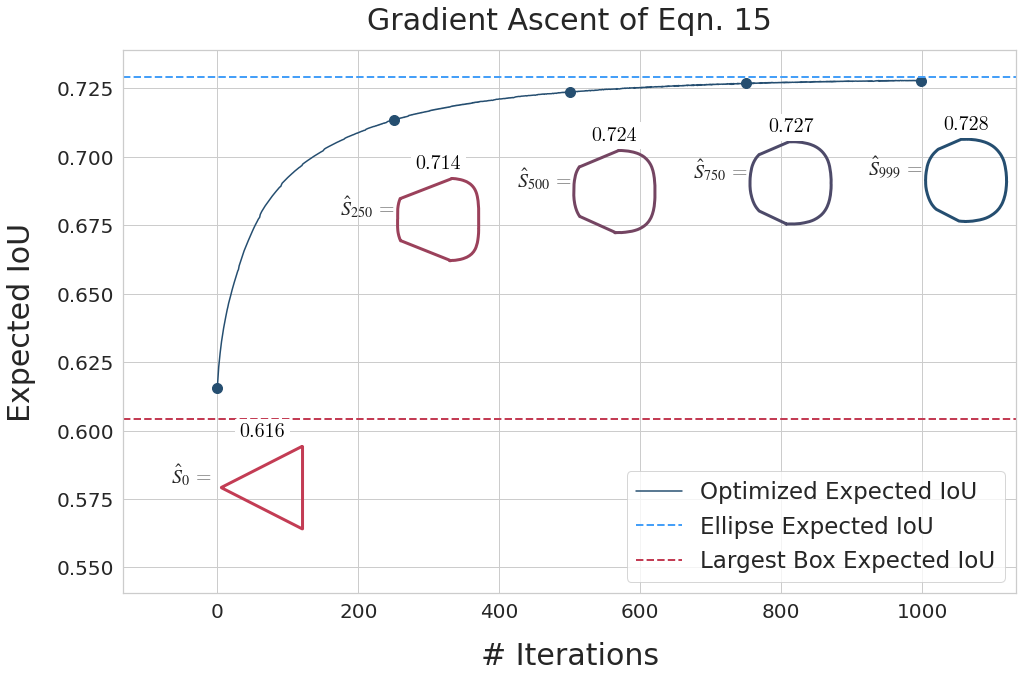

In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

snapshots = np.linspace(0, lim, num_snapshots).astype(np.int32)
if snapshots[-1] >= len(sample_ious):
    snapshots[-1] = len(sample_ious) - 1
    
smpl_ious = sample_ious[snapshots]
polys = [sample_polygons[i] for i in snapshots]

# generate colours to draw the graph
ru_colour = np.array([[69, 159, 248]]) / 255
indigo = np.array([[37, 78, 112]]) / 255
brickred = np.array([[195, 60, 84]]) / 255
optim_colors = np.expand_dims(np.linspace(0, 1, len(polys)), 1)
optim_colors = np.dot(optim_colors, indigo) + np.dot(1 - optim_colors, brickred)

# some styling, white grid, math fonts, sizing
sns.set_context(context="notebook")
sns.set_theme(style="whitegrid")
rc = {"mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
font = fm.FontProperties(fname="cmunrm.ttf")
sns.despine()

# define figure size, xlim, and ylim
fig = plt.figure(figsize=(16, 10), linewidth=4)
xmin, xmax = -lim / 7.5, lim + lim / 7.5
ymin, ymax = min([ell_iou - 0.01, lrg_iou - 0.01, sample_ious.min() - 0.075]), max([ell_iou + 0.01, lrg_iou + 0.01, sample_ious.max() + 0.01])
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)

plt.xlabel("# Iterations", labelpad=20, fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel("Expected IoU", labelpad=20, fontsize=30)
plt.yticks(fontsize=20)

plt.title("Gradient Ascent of Eqn. 15", pad=20, fontsize=30)

# plot IoU as it improved during the optimization
plt.plot(np.arange(len(sample_ious[:lim])), sample_ious[:lim], color=indigo[0], label="Optimized Expected IoU")

# place markers at snapshots
plt.scatter(snapshots, smpl_ious, s=100, color=indigo[0])

# draw lines marking the expected IoU for ellipse and largest box method
plt.axhline(y=ell_iou, color=ru_colour[0], linewidth=2, linestyle="--", label="Ellipse Expected IoU")
plt.axhline(y=lrg_iou, color=brickred[0], linewidth=2, linestyle="--", label="Largest Box Expected IoU")

plt.legend(loc='lower right', fontsize=23)

for j, poly in enumerate(polys):
    
    # generate sub-axis to draw polygon
    dim = 0.5 / len(polys)
    x = (snapshots[j] - xmin) / (xmax - xmin)
    y = (smpl_ious[j] - ymin) / (ymax - ymin) - dim / (0.6 * w / h) - 0.1
    
    axesj = fig.axes[0].inset_axes([x, y, dim, dim / (0.6 * w / h)])
    axesj.plot(poly.exterior.xy[0], poly.exterior.xy[1], linewidth=3, color=optim_colors[j])
    
    axesj.set_xticks([])
    axesj.set_frame_on(False)
    axesj.set_yticks([])
 
    # draw labels and IoU
    axesj.set_ylabel("$\hat S_{%d}$ = " % (snapshots[j]), labelpad=25, fontsize=20, rotation=0, fontproperties=font)
    axesj.set_title(round(smpl_ious[j], 3), fontsize=20, color="black", fontproperties=font, backgroundcolor= 'white')